In [1]:
!pip install gdown --no-use-pep517
!sudo apt-get install -y unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Dataset
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [5]:
%%bash
unzip -qo bard.zip

In [6]:
# Exploring pretrained word vectors to tf hub module
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  26.6M      0  0:00:31  0:00:31 --:--:-- 28.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7500  100  7500    0     0  34183      0 --:--:-- --:--:-- --:--:-- 34246


In [7]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2023-08-27 12:22:37.787895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-27 12:23:01.777340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 240002400 exceeds 10% of free system memory.
INFO:tensorflow:Assets written to: text_module/assets
I0827 12:23:03.373862 139572384706560 builder_impl.py:797] Assets written to: text_module/assets


In [8]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

In [9]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক'])

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

In [11]:
# convert to tf dataset
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []

for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels +=[i]*len(os.listdir(dir))

np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

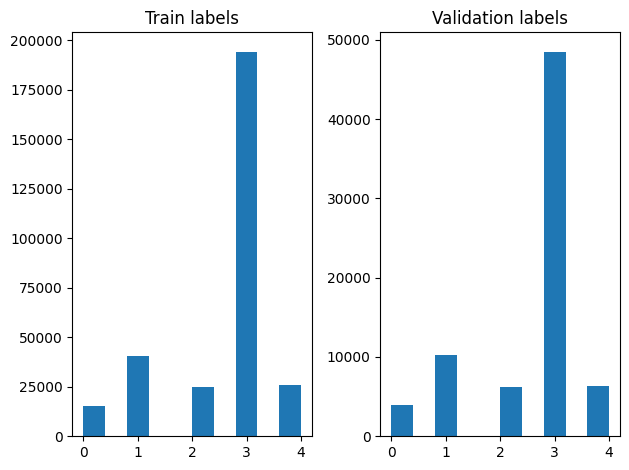

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

In [18]:
def load_file(path, label):
  return tf.io.read_file(path), label

In [19]:
def make_datasets(train_size):
  batch_size = 256
  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train_ds, test_ds

In [20]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

In [25]:
# model
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape = [], dtype = tf.string),
      embedding_layer,
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])
  return model

In [26]:
model = create_model()

In [27]:
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

# Training

In [29]:
history = model.fit(train_data, validation_data = validation_data, epochs = 20, callbacks = [early_stopping_callback])

Epoch 1/20
1176/1176 [==============================] - 203s 167ms/step - loss: 0.2115 - accuracy: 0.9270 - val_loss: 0.1464 - val_accuracy: 0.9482
Epoch 2/20
1176/1176 [==============================] - 107s 91ms/step - loss: 0.1355 - accuracy: 0.9517 - val_loss: 0.1341 - val_accuracy: 0.9500
Epoch 3/20
1176/1176 [==============================] - 80s 68ms/step - loss: 0.1222 - accuracy: 0.9553 - val_loss: 0.1182 - val_accuracy: 0.9571
Epoch 4/20
1176/1176 [==============================] - 81s 69ms/step - loss: 0.1148 - accuracy: 0.9577 - val_loss: 0.1149 - val_accuracy: 0.9582
Epoch 5/20
1176/1176 [==============================] - 91s 77ms/step - loss: 0.1093 - accuracy: 0.9595 - val_loss: 0.1139 - val_accuracy: 0.9581
Epoch 6/20
1176/1176 [==============================] - 89s 76ms/step - loss: 0.1051 - accuracy: 0.9606 - val_loss: 0.1173 - val_accuracy: 0.9570
Epoch 7/20
1176/1176 [==============================] - 91s 77ms/step - loss: 0.1008 - accuracy: 0.9623 - val_loss: 0.109

# Evaluation

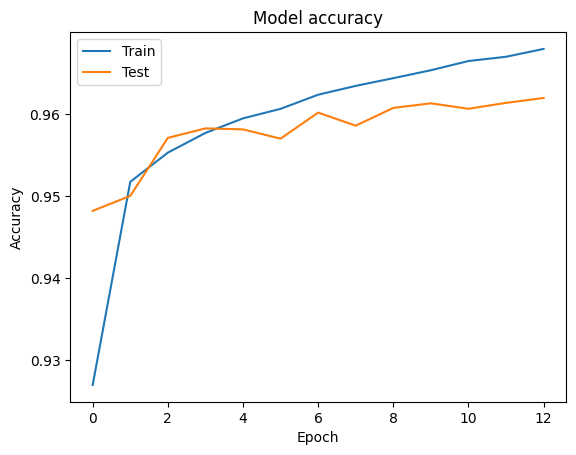

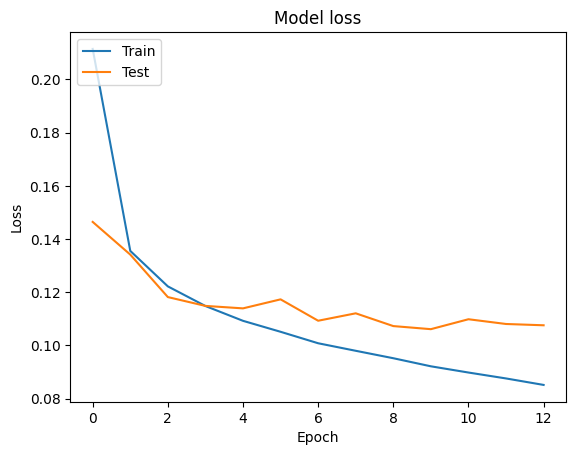

In [30]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [31]:
y_pred = model.predict(validation_data)

294/294 [==============================] - 15s 52ms/step


In [32]:
y_pred = np.argmax(y_pred, axis=1)

In [33]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()


অভিনেতা হিসেবেই সবাই চেনেন অপূর্বকে। তাও আবার রোমান্টিক অভিনেতা। তবে এবার সম্ভবত নতুন পরিচয় বেরিয়ে 
True Class:  entertainment
Predicted Class:  state

রোটারি বাংলাদেশের দুই দিনব্যাপী সম্মেলন গতকাল শনিবার রাজধানীতে শেষ হয়েছে। সম্মেলনে প্রধান অতিথি ছিল
True Class:  state
Predicted Class:  state

২৫, ২৯ ,৫*। কুমার সাঙ্গাকারাকে ঠিক চেনা যাচ্ছিল না ঢাকা ডায়নামাইটসের প্রথম তিন ম্যাচে। ঢাকা-পর্ব শে
True Class:  sports
Predicted Class:  state


In [34]:
y_true = np.array(labels[train_size:])

In [35]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.82      0.81      0.81      3897
       sports       0.99      0.99      0.99     10204
entertainment       0.93      0.94      0.94      6256
        state       0.98      0.97      0.97     48512
international       0.93      0.94      0.94      6377

     accuracy                           0.96     75246
    macro avg       0.93      0.93      0.93     75246
 weighted avg       0.96      0.96      0.96     75246

